In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import corner
import scipy.constants as con
import pandas as pd

#load data
data = np.loadtxt('data.dat')
time = data[:,0] - np.median(data[:,0])
flux = data[:,1]
fluxerr = data[:,2]

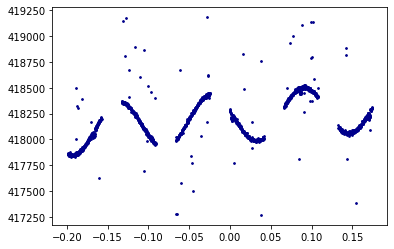

In [2]:
plt.scatter(time, flux, s=3, color="darkblue")

In [3]:
obs_start = np.array((*(1 + np.where(np.diff(time) > 0.001)[0]), len(time)-1))
time[obs_start]

array([-0.13261111, -0.06630556,  0.        ,  0.06630556,  0.13261111,
        0.17416667])

In [4]:
obs_start

array([ 268,  536,  802, 1065, 1335, 1604], dtype=int64)

In [5]:
gaps = np.vstack((time[obs_start-1], time[obs_start])).T[:5]
gaps

array([[-0.15736111, -0.13261111],
       [-0.09105556, -0.06630556],
       [-0.02475   ,  0.        ],
       [ 0.04155556,  0.06630556],
       [ 0.10786111,  0.13261111]])

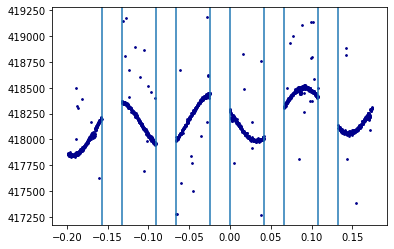

In [6]:
plt.scatter(time, flux, s=3, color="darkblue")
for i in range(5):
    plt.axvline(gaps[i][0])
    plt.axvline(gaps[i][1])

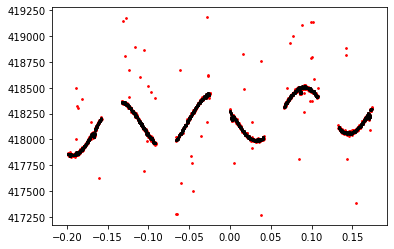

In [30]:
fluxpd = pd.Series(flux)
timepd = pd.Series(time)

fluxmed = fluxpd[:obs_start[0]-1].rolling(5).median()
timemed = timepd[:obs_start[0]-1].rolling(5).median()

for i in range(len(obs_start)-1):
    fluxmed = pd.concat([fluxmed, fluxpd[obs_start[i]:obs_start[i+1]-1].rolling(5).median()])
    timemed = pd.concat([timemed, timepd[obs_start[i]:obs_start[i+1]-1].rolling(5).median()])

plt.scatter(time, flux, s=3, color="red")
plt.scatter(timemed, fluxmed, s=3, color="black")

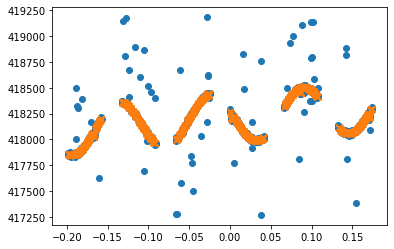

In [31]:
timepts = np.linspace(time[0], time[len(time)-1], 2000)
fluxinterp = np.interp(time, timemed, fluxmed)
plt.plot(time, flux, 'o')
plt.plot(time, fluxinterp, '-x')

In [70]:
bad = []
good = []
for i in range(len(time)):
    if abs(flux[i] - fluxinterp[i]) > 3*fluxerr[i]:
        bad.append([time[i], flux[i], fluxerr[i]])
    else:
        good.append([time[i], flux[i], fluxerr[i]])
del good[198]
del good[806]

In [71]:
good = np.array(good)
bad = np.array(bad)

gtime = good[:,0]
gflux = good[:,1]
gfluxerr = good[:,2]
btime = bad[:,0]
bflux = bad[:,1]
bfluxerr = bad[:,2]

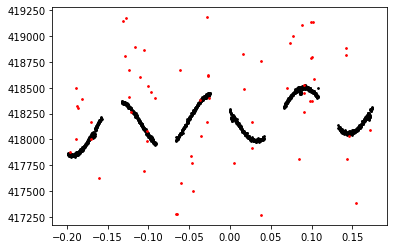

In [72]:
plt.scatter(gtime, gflux, color="black", s=3)
plt.scatter(btime, bflux, color="red", s=3)

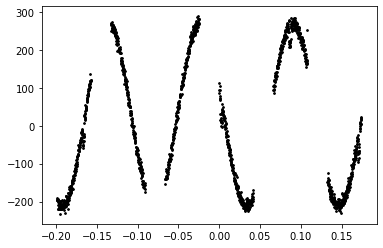

In [73]:
tempslope = np.polyfit(gtime, gflux, 1)
periodogramdata = gflux - (tempslope[1] + tempslope[0]*gtime)
plt.scatter(gtime, periodogramdata, s=3, color="black")

In [74]:
from scipy.signal import lombscargle

gtime = np.ascontiguousarray(gtime)

freqs = np.linspace(0.001, 200, 50000)
pgram = lombscargle(gtime, periodogramdata, freqs)

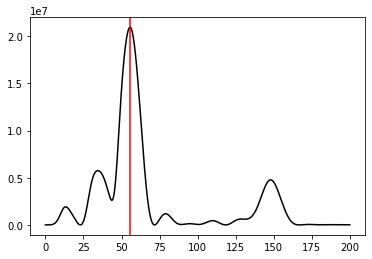

In [75]:
freqbest = freqs[np.argmax(pgram)]
plt.plot(freqs, pgram, color="black")
plt.axvline(freqbest, color="red")

In [76]:
#normal equation
Y = periodogramdata
X = np.asarray([np.sin(freqbest*gtime), np.cos(freqbest*gtime), np.ones(len(gtime))]).T
W = np.diag(gfluxerr)
beta = np.linalg.solve((X.T)@W@X, (X.T)@W@Y)

In [77]:
def model(time, beta):
    return beta[0]*np.sin(freqbest*time) + beta[1]*np.cos(freqbest*time) + beta[2]

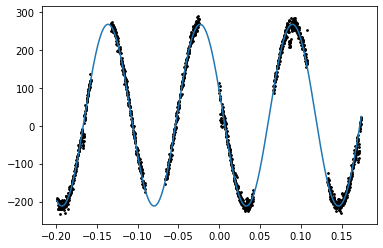

In [78]:
times = np.linspace(time[0], time[(len(time))-1], 10000)
plt.plot(times, model(times, beta))
plt.scatter(gtime, periodogramdata, s=3, color="black")

In [79]:
np.where(periodogramdata/model(gtime, beta)>30)

(array([], dtype=int64),)

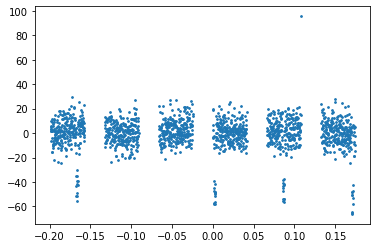

In [105]:
plt.scatter(gtime, periodogramdata - model(gtime, beta), s=3)

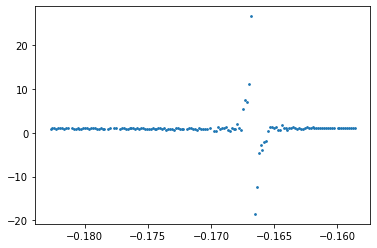

In [104]:
plt.scatter(gtime[100:250], periodogramdata[100:250]/model(gtime[100:250], beta), s=3)

In [87]:
med = np.median(periodogramdata[100:250]-model(gtime[100:250], beta))

In [102]:
np.where(periodogramdata[100:250]-model(gtime[100:250], beta)<(med-30))

(array([ 93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104],
       dtype=int64),)

-46.62361054240081